In [99]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [100]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.01024  # in s
signal_power = 1.0  # in dB
noise_power = 18.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=2)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)
sig += wm.soft(f_center=-2e5, power=signal_power+2, dB=True)
sig += wm.soft(f_center=1e5, power=signal_power-3, dB=True)
sig += wm.soft(f_center=2.5e5, power=signal_power+3, dB=True)
sig += wm.soft(f_center=1.5e5, power=signal_power+6, dB=True)
sig += wm.soft(f_center=-2.5e5, power=signal_power+3, dB=True)
sig += wm.soft(f_center=2e5, power=signal_power+6, dB=True)
sig += wm.soft(f_center=-1.5e5, power=signal_power+5, dB=True)
sig += wm.soft(f_center=.5e5, power=signal_power+3, dB=True)
sig += wm.soft(f_center=-.5e5, power=signal_power+2, dB=True)
sig += wm.soft(f_center=0e5, power=signal_power+1, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=1)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise
# both = noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 14.62 dB
Noise power:  17.95 dB
SNR:          -3.32 dB
Num samples:  10240


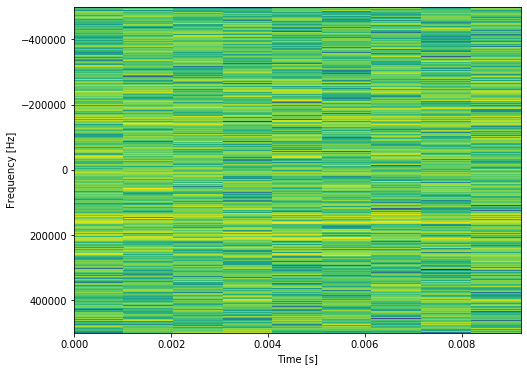

In [101]:
# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=both,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024)

In [102]:
# def mdl_citerion(L, N, eigs, M):
#     '''Minimum description length criterion function.'''
#     eigs = eigs[M:]  # select the last M eigenvalues
#     prod = np.prod(eigs**(1 / (L - M)))
#     summ = np.sum(eigs) / (L - M)
#     return -(L - M) * N * np.log(
#         prod / summ) + .5 * M * (2 * L - M) * np.log(N)


# def noise_eigvals(x, n, l=50):
#     assert len(x) == n, 'Length does not match n'
#     assert len(x) > l, 'Length cant be smaller than l'
#     c = n / l
#     print('n', n, 'l', l, 'c', c)
    
#     # claculate covariance matrix
#     mat = ss.eigen_detector.corr(x, l)
    
#     plt.figure(figsize=(8, 6))
#     plt.imshow(np.abs(mat))
#     plt.colorbar()
#     plt.show()
    
#     # get sorted eigenvalues
#     eigs = np.sort(np.abs(linalg.eigvals(mat)))[::-1]
    
#     plt.figure(figsize=(8, 6))
#     plt.plot(eigs, 'o')
#     plt.grid(linewidth=0.5)
#     plt.show()
    
#     # calculate mdl
#     mdl = list(map(lambda x: mdl_citerion(l, n, eigs, x), np.arange(l)))
    
#     plt.figure(figsize=(8, 6))
#     plt.plot(mdl, 'o')
#     plt.grid(linewidth=0.5)
#     plt.yscale('log')
#     plt.show()
    
#     # get optimal m (find first noise eignvalue index)
#     m = np.argmin(mdl)
    
#     print('m', m)
    
#     # noise only eigenvalues
#     noise_eigs = eigs[m:]
    
#     plt.figure(figsize=(8, 6))
#     plt.plot(noise_eigs, 'o')
#     plt.grid(linewidth=0.5)
#     plt.show()
    
#     return noise_eigs, m
    

# noise_eigs, m = noise_eigvals(both, num_samples, l=50)

# print('act', ss.util.dB_to_factor_power(noise_power))
# print('est', np.mean(noise_eigs))

100%|██████████| 10190/10190 [00:00<00:00, 79941.86it/s]


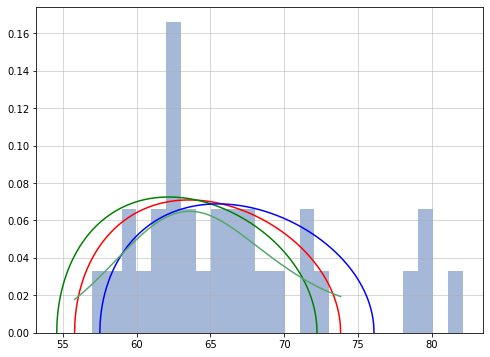

act 18.0
est 18.226284855714056
opt 18.095137515202584


In [103]:
def mdl_citerion(L, N, eigs, M):
    '''Minimum description length criterion function.'''
    eigs = eigs[M:]  # select the last M eigenvalues
    prod = np.prod(eigs**(1 / (L - M)))
    summ = np.sum(eigs) / (L - M)
    return -(L - M) * N * np.log(
        prod / summ) + .5 * M * (2 * L - M) * np.log(N)


def marchenko_pastur_pdf(var, c, res):
    v_max, v_min = var * (1 + c**.5)**2., var * (1 - c**.5)**2.
    v = np.linspace(v_min, v_max, res)
    return v, ((v - v_min) * (v_max - v))**.5 / (2. * np.pi * var * v * c)

def empirical_dist(eigs, v):
#     w = np.linspace(1., 1.2, len(eigs))
#     return stats.gaussian_kde(eigs, bw_method='scott', weights=w).evaluate(v)
    return stats.gaussian_kde(eigs, bw_method='scott').evaluate(v)


def goodness_fit(n, c, beta, res, eigs, var):
    v, mp = marchenko_pastur_pdf(var, (1 - beta) * c, res=res)
    kde = empirical_dist(eigs, v)
    return linalg.norm(kde - mp)


def noise_eigvals(x, n, l=50, res=1000):
    assert len(x) == n, 'Length does not match n'
    assert len(x) > l, 'Length cant be smaller than l'

    # claculate covariance matrix
    mat = ss.eigen_detector.corr(x, l)

    # get sorted eigenvalues
    eigs = np.sort(np.abs(linalg.eigvals(mat)))[::-1]

    # calculate mdl
    mdl = list(map(lambda x: mdl_citerion(l, n, eigs, x), np.arange(l)))

    # get optimal m (find first noise eignvalue index)
    m = np.argmin(mdl)

    # noise only eigenvalues
    noise_eigs = eigs[m:]

    c = l / n
    beta = m / l

    pis = np.linspace(noise_eigs[-1] / (1 - c**.5)**2 * .9,
                      noise_eigs[0] / (1 + c**.5)**2 * 1.1, res)

    diffs = list(map(lambda x: goodness_fit(n, c, beta, res, noise_eigs, var=x), pis))

#     plt.figure(figsize=(8, 6))
#     plt.plot(pis, diffs, ',')
#     plt.grid(linewidth=0.5)
#     plt.show()
    
    noise_est_mean = np.mean(noise_eigs)
    
    noise_est_good_fit = pis[np.argmin(diffs)]
    
    v, mp = marchenko_pastur_pdf(noise_est_good_fit, c, res)
    v1, mp1 = marchenko_pastur_pdf(ss.util.dB_to_factor_power(noise_power), c, res)
    v2, mp2 = marchenko_pastur_pdf(noise_est_mean, c, res)
    plt.figure(figsize=(8, 6))
    plt.plot(v, mp, 'r-')
    plt.plot(v1, mp1, 'g-')
    plt.plot(v2, mp2, 'b-')
    plt.hist(noise_eigs, bins=l//2, density=True, alpha=0.5)
    plt.plot(v, empirical_dist(noise_eigs, v))
    plt.grid(linewidth=0.5)
    plt.show()

    return noise_est_mean, noise_est_good_fit


est, opt = noise_eigvals(both, num_samples, l=50)

print('act', noise_power)
print('est', ss.util.dB_power(est))
print('opt', ss.util.dB_power(opt))